In [555]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth',50)
pd.set_option('max_columns',250)
pd.set_option('max_rows',500)

#visualizations
import folium
from folium import plugins
from folium.plugins import HeatMap
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns 
import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from mpl_toolkits.basemap import Basemap
%matplotlib inline 
cf.go_offline()
cf.set_config_file(world_readable=True,theme='white') # Make all charts public and set a global theme
sns.set_style("whitegrid") #possible choices: white, dark, whitegrid, darkgrid, ticks

### Define function for dataset statistics

In [171]:
def get_stats(df, sort_by='Different Values', sort_how=False, exclude=[], include_only=[], target='target'):
        columns = [c for c in df.columns.values if c not in exclude and c in include_only]
        df=df[columns]
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Data types
        data_types = df.dtypes
        
        # Different Values
        other_values = pd.DataFrame(columns=['Different Values','Most Common','% of Most Common','Skewness',
                                            'Kurtosis','Mean','Min','25% quantile','Median','75% quantile','Max'])
        for c in columns:
            if (df[c].dtype != 'object'):
                other_values = other_values.append({
                    'Name' : c,
                    'Different Values' : df[c].value_counts().count(),
                    'Most Common' : df[c].value_counts().idxmax(),
                    '% of Most Common' : 100*df[c].value_counts().max() / df[c].value_counts().sum(),
                    'Skewness' : df[c].skew(),
                    'Kurtosis' : df[c].kurt(),
                    'Mean' : df[c].mean(),
                    'Min' : df[c].min(),
                    '25% quantile' : df[c].quantile(0.25),
                    'Median' : df[c].median(),
                    '75% quantile' : df[c].quantile(0.75),
                    'Max' : df[c].max(),
                                                    }, ignore_index=True)
            else:
                other_values = other_values.append({
                    'Name' : c,
                    'Different Values' : df[c].value_counts().count(),
                    'Most Common' : df[c].value_counts().idxmax(),
                    '% of Most Common' : 100*df[c].value_counts().max() / df[c].value_counts().sum()
                                                    }, ignore_index=True)                
        other_values = other_values.set_index('Name')
        
        
        # Make a table with the results
        mis_val_table = pd.concat([data_types, other_values, mis_val, mis_val_percent], axis=1, sort=False)       
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0:'Type',
                   'Different Values':'Different Values',
                   'Most Common':'Most Common',
                   '% of Most Common':'% of Most Common',
                   'Skewness':'Skewness', 
                   'Kurtosis':'Kurtosis', 
                   1:'Missing Values', 
                   2:'% of Missing Values',
                   'Mean' : 'Mean',
                   'Min' : 'Min',
                   '25% quantile' : '25% quantile',
                   'Median' : 'Median',
                   '75% quantile' : '75% quantile',
                   'Max' : 'Max',
        })
        
        # Sort the table 
        mis_val_table_ren_columns = mis_val_table_ren_columns.sort_values(sort_by, ascending=sort_how)
        df = mis_val_table_ren_columns
        
        # Re-arrange columns
        #cols = df.columns.tolist()
        #cols = cols[0:1] + cols[7:8]# + cols[0:1] + cols[2:3] + cols[3:4] + cols[5:6] + cols[4:5] + cols[6:7] +cols[7:8] +cols[8:9] + cols[9:10]
        #df = df[cols]
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[0]) + " columns. (" +
        str(df[df['Type']=='object'].shape[0])+" categorical and "+str(df[df['Type']!='object'].shape[0])+" numerical).\n"
        "There are " + str(df[df['Missing Values']>0].shape[0]) +" columns that have missing values, of which " +
        str(df[df['% of Missing Values']>=90].shape[0]) + " have over 90%!\n" +
        str(df[(df['Type']=='object')&(df['Different Values']<5)].shape[0]) + 
        " object type columns have less than 5 different values and you can consider one-hot encoding, while " + 
        str(df[(df['Type']=='object')&(df['Different Values']>=5)].shape[0]) +
        " have more than 5 colums and you can consider label encoding.\n" +
        str(df[df['Skewness']>1].shape[0]) + " columns are highly positively skewed (skewness>1), while " +
        str(df[df['Skewness']<-1].shape[0]) + " columns are highly negatively skewed (skewness<-1).\n" +
        str(df[(df['Skewness']>-0.5)&(df['Kurtosis']<0.5)].shape[0]) + " columns are symmetrical (-0.5<skewness<0.5).\n" +
        str(df[df['Kurtosis']>3].shape[0]) + " columns have high kurtosis (kurtosis>3) and should be check for outliers, while " + 
        str(df[df['Kurtosis']<3].shape[0]) + " columns have low kurtosis (kurtosis<3). "
        )        
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

### Define function for Univariate Plots

In [172]:
def plot_univariate(df, plot_title):
    hist_data = []
    hist_data.extend([df])
        
    group_labels = ['Surface Temperature']
    fig = ff.create_distplot(hist_data, group_labels, show_hist=True)
    distplot1=fig['data']
    
    trace = go.Box(y=df, name='', pointpos = -1.8, jitter = 0.3, boxpoints = 'all') 

    my_fig = tls.make_subplots(rows=1, cols=2, print_grid=False)
    my_fig.layout.update(title=plot_title, barmode = 'overlay', bargap=0.04, height=360, width=940, showlegend=False)

    my_fig.append_trace(distplot1[0], 1, 1)
    my_fig.append_trace(distplot1[1], 1, 1)
    my_fig.append_trace(trace, 1, 2)
    iplot(my_fig)

### Define function for Map Plot

In [579]:
def plot_map(df,variable,title):
    # How much to zoom from coordinates (in degrees)
    zoom_scale = 0
    lats = df['Center Lat'].tolist()
    lons = df['Center Long'].tolist()
    prob = df[variable].tolist()

    # Setup the bounding box for the zoom and bounds of the map
    bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
            np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, fontsize = 20, loc='center')
    matplotlib.rcParams.update({'font.size': 14})
    # Define the projection, scale, the corners of the map, and the resolution.
    m = Basemap(projection='cyl',llcrnrlat=bbox[0],urcrnrlat=bbox[1], llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='h')
    m.bluemarble()

    # Draw coastlines and fill continents and water with color
    m.drawcoastlines()
    #m.fillcontinents(color='#CCCCCC',lake_color='lightblue')

    # draw parallels, meridians, and color boundaries
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=15)
    m.drawmapboundary(fill_color='lightblue')

    # format colors for elevation range
    alt_min = np.min(prob)
    alt_max = np.max(prob)
    cmap = plt.get_cmap('jet') #jet,nipy_spectral,YlOrRd,hot_r
    normalize = matplotlib.colors.Normalize(vmin=alt_min, vmax=alt_max)

    from matplotlib.patches import Rectangle
    from matplotlib.patches import FancyBboxPatch

    # the range [50,250] can be changed to create different colors and ranges
    for ii in range(0,len(prob)):
        x,y = m(lons[ii],lats[ii])
        color_interp = np.interp(prob[ii],[alt_min,alt_max],[50,250])   
        rect=plt.Rectangle(xy=(x-0.25,y-0.25),linewidth=0.6, width=0.5,height=0.5,fill=True, alpha=0.8,color=cmap(int(color_interp)))
        border=plt.Rectangle(xy=(x-0.25,y-0.25),linewidth=0.2, width=0.5,height=0.5,fill=False, alpha=0.7,color="#000088")
        ax.add_patch(rect);ax.add_patch(border)

    # format the colorbar 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,norm=normalize)

    # save the figure and show it
    #plt.savefig(title+'.png', format='png', dpi=500,transparent=True)
    plt.show()    

# Sardina Pilchardus

|    | Scientific name          | Common_name_GRE | Common_name_ENG        | Habitat       | Depth range (m) | Usual depth range (m) |
|----|--------------------------|-----------------|------------------------|---------------|-----------------|-----------------------|
|   | Sardina pilchardus       | Σαρδέλα         | European sardine       | Pelagic       | 10-100          | 25-100                |
<img src="imgs/sardina.jpg" alt="Sardina pilchardus" width="200px" align="center"/>

In [173]:
# panel data
sardinaPilchardus_panel = pd.read_csv('T:/ownCloud/ODYSSEA/Aquamaps/the16species_final/Sardina pilchardus.csv',index_col='Unnamed: 0')
print(sardinaPilchardus_panel.shape[0], 'rows')

71520 rows


In [174]:
sardinaPilchardus_panel.head()

id    Genus     Species  Center Lat  Center Long C-Square Code  \
0  02008-01  Sardina  pilchardus       30.75        17.75    1301:207:4   
1  02008-02  Sardina  pilchardus       30.75        17.75    1301:207:4   
2  02008-03  Sardina  pilchardus       30.75        17.75    1301:207:4   
3  02008-04  Sardina  pilchardus       30.75        17.75    1301:207:4   
4  02008-05  Sardina  pilchardus       30.75        17.75    1301:207:4   

   Overall Probability  obs_id  temperatureSurface year_month  \
0                 0.12     0.0           17.487333    2008-01   
1                 0.12     0.0           16.356483    2008-02   
2                 0.12     0.0           17.412617    2008-03   
3                 0.12     0.0           18.664886    2008-04   
4                 0.12     0.0           20.683325    2008-05   

   temperature100_300  temperature300_400  temperature100_500  \
0           17.483358           17.483358           17.483358   
1           16.323410           16.323410           16.323410   
2           17.323942           17.323942           17.323942   
3           18.580479           18.580479           18.580479   
4           20.466887           20.466887           20.466887   

   temperatureMaxDepth  salinitySurface  salinity100_300  salinity300_400  \
0            17.483358        38.589620        38.589687        38.589687   
1            16.323410        38.357500        38.356500        38.356500   
2            17.323942        38.330997        38.329420        38.329420   
3            18.580479        38.356586        38.354680        38.354680   
4            20.466887        38.414630        38.409603        38.409603   

   salinity100_500  salinityMaxDepth  dissolvedOxygenSurface  \
0        38.589687         38.589687               215.00977   
1        38.356500         38.356500               222.06847   
2        38.329420         38.329420               222.28883   
3        38.354680         38.354680               217.55254   
4        38.409603         38.409603               211.78080   

   dissolvedOxygen100_300  dissolvedOxygen300_400  dissolvedOxygen100_500  \
0               215.00972               215.00972               215.00972   
1               222.06845               222.06845               222.06845   
2               222.28891               222.28891               222.28891   
3               217.55266               217.55266               217.55266   
4               212.11305               212.11305               212.11305   

   dissolvedOxygenMaxDepth  meridionalCurrentSurface  \
0                215.00972                 -0.004633   
1                222.06845                  0.000000   
2                222.28891                 -0.018918   
3                217.55266                 -0.015815   
4                212.11305                 -0.010033   

   meridionalCurrent100_300  meridionalCurrent300_400  \
0                 -0.004417                 -0.004417   
1                 -0.004417                 -0.004417   
2                 -0.017599                 -0.017599   
3                 -0.014742                 -0.014742   
4                 -0.009926                 -0.009926   

   meridionalCurrent100_500  meridionalCurrentMaxDepth  zonalCurrentSurface  \
0                 -0.004417                  -0.004417             0.003990   
1                 -0.004417                   0.000000             0.000000   
2                 -0.017599                  -0.017599             0.014905   
3                 -0.014742                  -0.014742             0.014309   
4                 -0.009926                  -0.009926             0.009827   

   zonalCurrent100_300  zonalCurrent300_400  zonalCurrent100_500  \
0             0.003799             0.003799             0.003799   
1             0.003799             0.003799             0.003799   
2             0.015852             0.015852             0.015852   
3             0.012531             0.0

### Create a new dataset with the mean value of each observation. This is the mean of 120 months.

In [180]:
### Create some lists that will be useful
static_cols = ['majorRiverDistance', 'majorRiversScale', 'bathymetry', 'substrateType','substrateOrigHabitat', 'substrateBiozone']
temporal_cols = ['temperatureSurface','temperature100_300', 'temperature300_400', 'temperature100_500','temperatureMaxDepth', 'salinitySurface', 'salinity100_300','salinity300_400', 'salinity100_500', 'salinityMaxDepth','dissolvedOxygenSurface', 'dissolvedOxygen100_300','dissolvedOxygen300_400', 'dissolvedOxygen100_500','dissolvedOxygenMaxDepth', 'meridionalCurrentSurface','meridionalCurrent100_300', 'meridionalCurrent300_400','meridionalCurrent100_500', 'meridionalCurrentMaxDepth','zonalCurrentSurface', 'zonalCurrent100_300', 'zonalCurrent300_400','zonalCurrent100_500', 'zonalCurrentMaxDepth', 'chlorophyll','EuphoticDepth', 'SecchiDiskDepth', 'wave_Height', 'nitrateSurface','nitrate100_300', 'nitrate300_400', 'nitrate100_500', 'nitrateMaxDepth','phosphateSurface', 'phosphate100_300', 'phosphate300_400','phosphate100_500', 'phosphateMaxDepth']


sardinaPilchardus = pd.DataFrame()
for c in sardinaPilchardus_panel.columns:
    if c in temporal_cols:
        sardinaPilchardus[c] = sardinaPilchardus_panel.groupby('obs_id')[c].mean()
        #sardinaPilchardus[c+'_mean'] = sardinaPilchardus_panel.groupby('obs_id')[c].mean()
    if c in static_cols:
        sardinaPilchardus[c] = sardinaPilchardus_panel.groupby('obs_id')[c].agg(lambda x:x.value_counts().index[0])
    if c in ['Center Lat','Center Long']:
        sardinaPilchardus[c] = sardinaPilchardus_panel.groupby('obs_id')[c].agg(lambda x:x.value_counts().index[0])
        
pelagic = [sardinaPilchardus]
pelagic_name = ['Sardina Pilchardus']

In [181]:
print(sardinaPilchardus.shape[0], 'rows and ', sardinaPilchardus.shape[1], 'columns')
sardinaPilchardus.head()

596 rows and  47 columns


Center Lat  Center Long  temperatureSurface  temperature100_300  \
obs_id                                                                    
0.0          30.75        17.75           22.373630           22.287897   
1.0          30.25        18.75           22.510767           22.427538   
2.0          30.75        18.75           22.382202           15.951561   
3.0          30.25        19.25           22.485016           22.335924   
4.0          30.25        19.75           22.514297           22.218005   

        temperature300_400  temperature100_500  temperatureMaxDepth  \
obs_id                                                                
0.0              22.287897           22.287897            22.287897   
1.0              22.427538           22.427538            22.427538   
2.0              15.951561           15.951561            15.951561   
3.0              22.335924           22.335924            22.335924   
4.0              22.218005           22.218005            22.218005   

        salinitySurface  salinity100_300  salinity300_400  salinity100_500  \
obs_id                                                                       
0.0           38.681165        38.677997        38.677997        38.677997   
1.0           38.713629        38.710803        38.710803        38.710803   
2.0           38.591174        38.666155        38.666155        38.666155   
3.0           38.738440        38.731926        38.731926        38.731926   
4.0           38.715601        38.699159        38.699159        38.699159   

        salinityMaxDepth  dissolvedOxygenSurface  dissolvedOxygen100_300  \
obs_id                                                                     
0.0            38.677997              203.782252              203.827622   
1.0            38.710803              203.325312              203.339973   
2.0            38.666155              201.167671              205.948226   
3.0            38.731926              200.794471              200.986942   
4.0            38.699159              200.720580              201.778111   

        dissolvedOxygen300_400  dissolvedOxygen100_500  \
obs_id                                                   
0.0                 203.827622              203.827622   
1.0                 203.339973              203.339973   
2.0                 205.948226              205.948226   
3.0                 200.986942              200.986942   
4.0                 201.778111              201.778111   

        dissolvedOxygenMaxDepth  meridionalCurrentSurface  \
obs_id                                                      
0.0                  203.827622                 -0.007706   
1.0                  203.339973                 -0.012922   
2.0                  205.948226                 -0.007238   
3.0                  200.986942                 -0.004965   
4.0                  201.778111                 -0.009709   

        meridionalCurrent100_300  meridionalCurrent300_400  \
obs_id                                                       
0.0                    -0.004464                 -0.004464   
1.0                    -0.006547                 -0.006547   
2.0                    -0.000512                 -0.000512   
3.0                     0.007940                  0.007940   
4.0                     0.006801                  0.006801   

        meridionalCurrent100_500  meridionalCurrentMaxDepth  \
obs_id                                                        
0.0                    -0.004464                  -0.003790   
1.0                    -0.006547                  -0.005820   
2.0                    -0.000512                  -0.000470   
3.0                     0.007940                   0.007571   
4.0                     0.006801                   0.006443   

        zonalCurrentSurface  zonalCurrent100_300  zonalCurrent300_400  \
obs_id                                                                  
0.0                0.001265             0.0060

## Temperature

In [177]:
get_stats(sardinaPilchardus, sort_by='Mean', sort_how=False, include_only=[c for c in sardinaPilchardus if 'temperature' in c])

Your selected dataframe has 5 columns. (0 categorical and 5 numerical).
There are 0 columns that have missing values, of which 0 have over 90%!
0 object type columns have less than 5 different values and you can consider one-hot encoding, while 0 have more than 5 colums and you can consider label encoding.
4 columns are highly positively skewed (skewness>1), while 0 columns are highly negatively skewed (skewness<-1).
5 columns are symmetrical (-0.5<skewness<0.5).
0 columns have high kurtosis (kurtosis>3) and should be check for outliers, while 5 columns have low kurtosis (kurtosis<3). 


Type Different Values  Most Common  % of Most Common  \
Name                                                                           
temperatureSurface   float64              582    17.580020          0.671141   
temperature100_300   float64              578    13.340175          0.671141   
temperature300_400   float64              580    14.717940          0.671141   
temperature100_500   float64              582    13.340175          0.671141   
temperatureMaxDepth  float64              582    14.717940          0.671141   

                     Skewness  Kurtosis       Mean        Min  25% quantile  \
Name                                                                          
temperatureSurface   0.304352  0.035650  19.945594  15.052781     18.954670   
temperature100_300   1.059039  0.416230  16.189127  11.977197     14.386262   
temperature300_400   1.099925  0.408620  16.051324  11.977197     14.210323   
temperature100_500   1.114732  0.394688  15.974469  11.977197     14.086748   
temperatureMaxDepth  1.070715  0.233067  15.807662  11.977197     13.622285   

                        Median  75% quantile        Max  Missing Values  \
Name                                                                      
temperatureSurface   19.718877     20.742275  23.591479               0   
temperature100_300   15.430706     17.566502  23.489089               0   
temperature300_400   15.198221     17.508607  23.489089               0   
temperature100_500   15.029283     17.504647  23.489089               0   
temperatureMaxDepth  14.818341     17.494714  23.489089               0   

                     % of Missing Values  
Name                                      
temperatureSurface                   0.0  
temperature100_300                   0.0  
temperature300_400                   0.0  
temperature100_500                   0.0  
temperatureMaxDepth                  0.0

In [178]:
plot_univariate(sardinaPilchardus['temperatureSurface'], 'Sardina Pilchardus Τemperature (Surface)')
plot_univariate(sardinaPilchardus['temperatureMaxDepth'], 'Sardina Pilchardus Τemperature (Seabed)')

In [450]:
bbox[0]

30.25

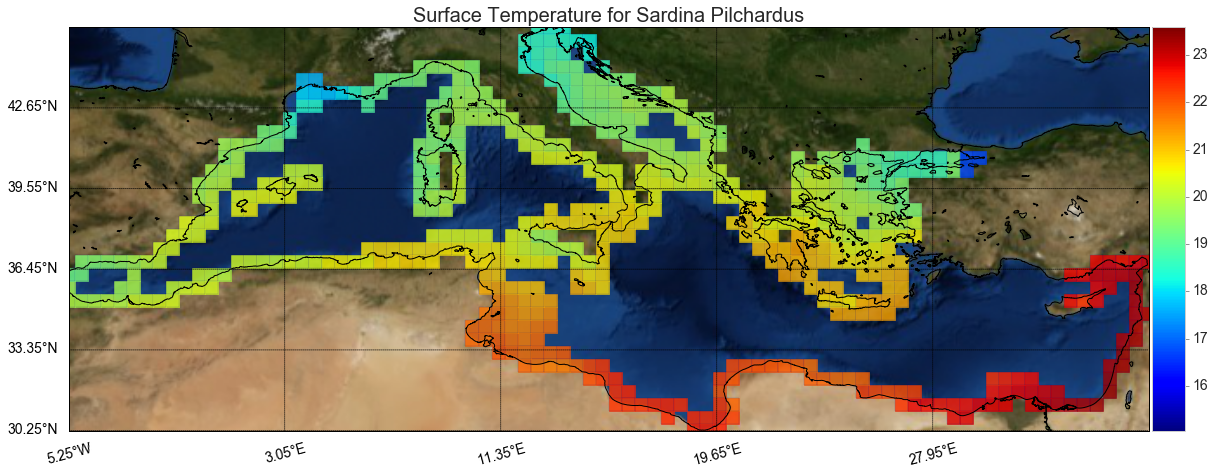

In [577]:
plot_map(sardinaPilchardus,'temperatureSurface','Surface Temperature for Sardina Pilchardus')